In [1]:
# from ..tests.test_bidiag_JVP_and_VJP_jax import bidiagonalize_vjpable
import jax
import jax.numpy as jnp
from jax import jit
from jax.experimental.ode import odeint
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from IPython.display import Image
from pendulum_utils import (
    simulate_double_pendulum,
    save_and_display_animation,
    plot_pendulum_state,
)

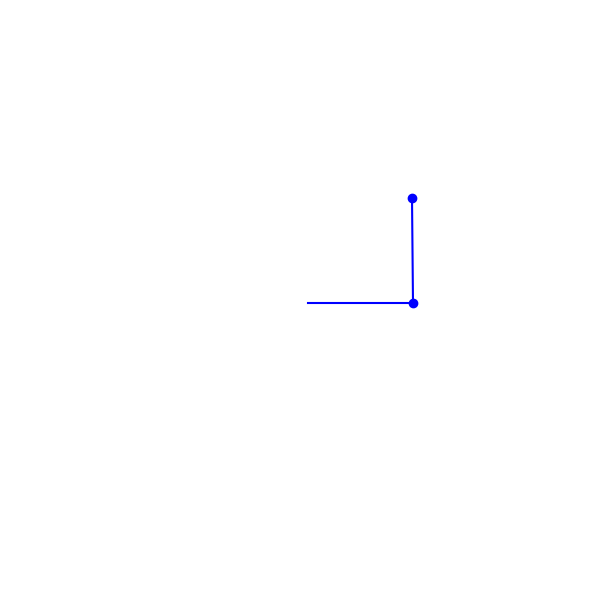

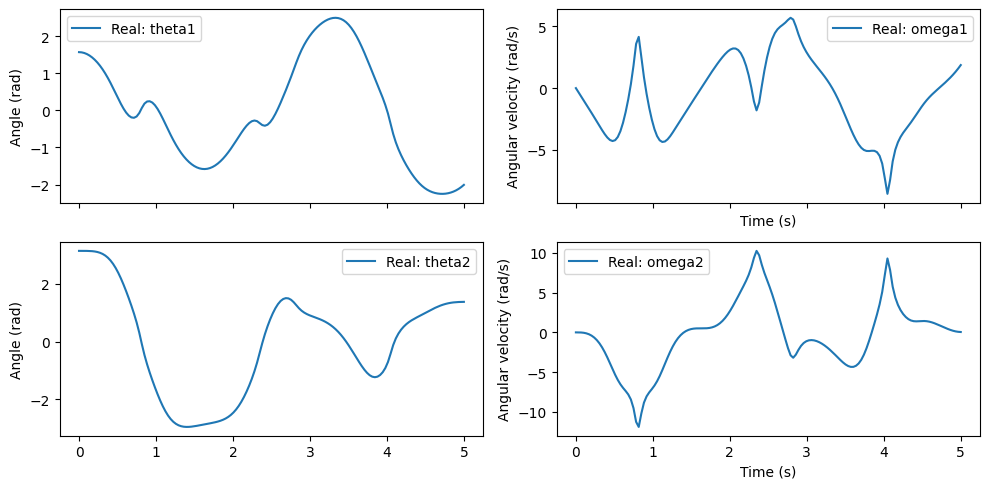

In [2]:
# Parameters and simulation
params = (1.0, 1.0, 1.0, 1.0, 9.81)  # masses, lengths, gravity
initial_state = jnp.array([jnp.pi / 2, 0.0, jnp.pi, 0.0])
fps = 1 / 0.03355705
seconds = 5.0
t = jnp.linspace(0.0, seconds, int(fps * seconds))
trajectory = simulate_double_pendulum(initial_state, t, params)

axs = plot_pendulum_state(trajectory, t, "Real")

save_and_display_animation(trajectory, fps, "real_pendulum")

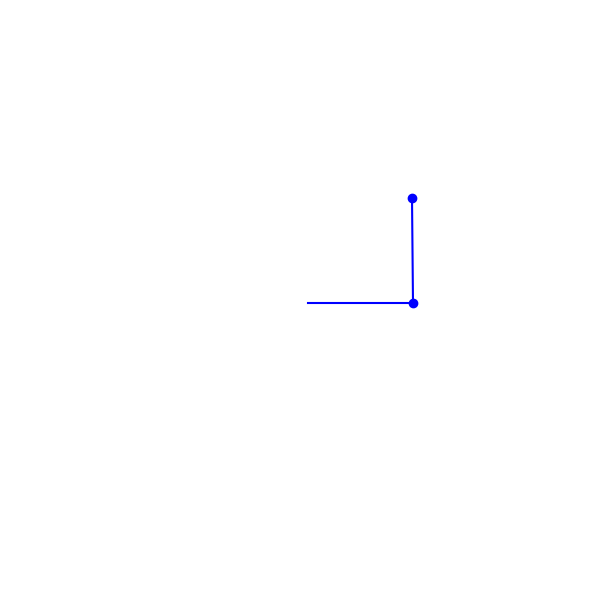

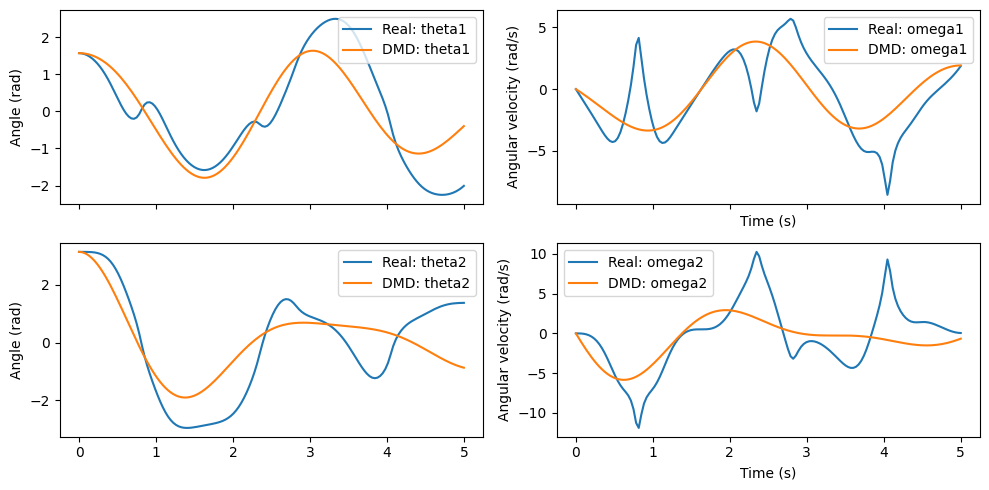

In [3]:
# Construct DMD dataset: X = [x0...x_{n-1}], X' = [x1...x_n]
X1 = trajectory[:-1].T  # shape (4, T-1)
X2 = trajectory[1:].T  # shape (4, T-1)

# Perform SVD on X1
U, S, Vh = np.linalg.svd(X1, full_matrices=False)

# Truncate rank (optional)
r = 4  # full rank
Ur = U[:, :r]
Sr = np.diag(S[:r])
Vr = Vh[:r, :]

# Compute Koopman (DMD) matrix
A_tilde = Ur.T @ X2 @ Vr.T @ np.linalg.inv(Sr)
A_dmd = X2 @ Vr.T @ np.linalg.inv(Sr) @ Ur.T

# Predict forward from x_0 using DMD
x_pred = [X1[:, 0]]
for _ in range(len(X1.T)):
    x_pred.append(A_dmd @ x_pred[-1])
x_pred = np.stack(x_pred, axis=1).T  # shape (T-1, 4)

axs = plot_pendulum_state(trajectory, t, "Real")
plot_pendulum_state(x_pred, t, "DMD", axs)

save_and_display_animation(x_pred, fps, "DMD_pendulum")

In [6]:
import sys

sys.path.append("..")  # or the full path to your project root if needed

from train_tools import train_koopman_model

with jax.debug_nans(True):
    model, koopman_op = train_koopman_model(
        trajec=trajectory, latent_dim=16, lr=1e-4, steps=5000, matvecs=148, seed=1
    )

Step 0 | Loss: 8.53096
Step 100 | Loss: 7.78078
Step 200 | Loss: 4.62616
Step 300 | Loss: 1.83726
Step 400 | Loss: 1.26570
Step 500 | Loss: 1.08391
Step 600 | Loss: 0.82573
Step 700 | Loss: 0.48611
Step 800 | Loss: 0.37507
Step 900 | Loss: 0.21038
Step 1000 | Loss: 0.14817
Step 1100 | Loss: 0.12347
Step 1200 | Loss: 0.08415
Step 1300 | Loss: 0.05637
Step 1400 | Loss: 0.04112
Step 1500 | Loss: 0.03371
Step 1600 | Loss: 0.03080
Step 1700 | Loss: 0.02870
Step 1800 | Loss: 0.07563
Step 1900 | Loss: 0.07406
Step 2000 | Loss: 0.06808
Step 2100 | Loss: 0.03553
Step 2200 | Loss: 0.02629
Step 2300 | Loss: 0.04987
Step 2400 | Loss: 0.02998
Step 2500 | Loss: 0.02224
Step 2600 | Loss: 0.01759
Step 2700 | Loss: 0.01769
Step 2800 | Loss: 0.05732
Step 2900 | Loss: 0.04956
Step 3000 | Loss: 0.02839
Step 3100 | Loss: 0.01763
Step 3200 | Loss: 0.08730
Step 3300 | Loss: 0.03854
Step 3400 | Loss: 0.02517
Step 3500 | Loss: 0.01725
Step 3600 | Loss: 0.01286
Step 3700 | Loss: 0.04369
Step 3800 | Loss: 0.0487

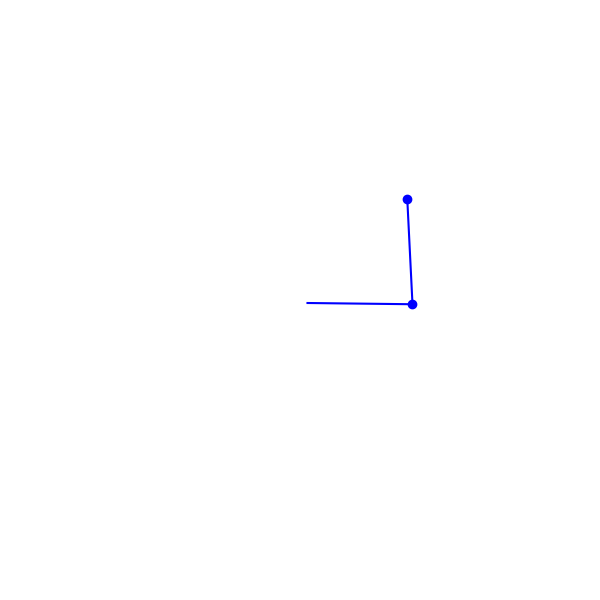

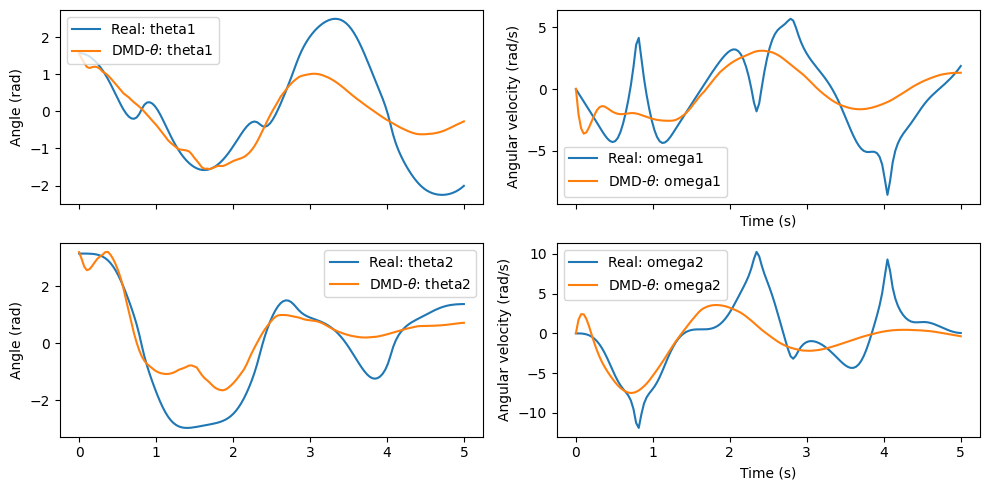

In [7]:
# phi_next_hat = (A_koop @ phi_t.T).T  # (T-1, k)
# x_next_hat = jax.vmap(model.decode)(phi_next_hat)

all_encoded = jax.vmap(lambda x: model.encode(x))(trajectory)
latent_seq = [model.encode(trajectory[0, :])]
for g in range(len(trajectory) - 1):
    if True:  # g % 5 <= 3:
        latent_seq.append(koopman_op @ latent_seq[-1].T)
    else:
        latent_seq.append(all_encoded[g + 1].T)
latent_seq = np.stack(latent_seq, axis=1).T  # shape (T-1, 4)
decoded = jax.vmap(lambda x: model.decode(x))(latent_seq)

# save_and_display_animation(decoded, 1.0, "trained_DMD_pendul")
axs = plot_pendulum_state(trajectory, t, "Real")
plot_pendulum_state(decoded, t[: len(decoded)], r"DMD-$\theta$", axs)
# make gif:
save_and_display_animation(decoded, fps, "latent_DMD_pendulum", override_existing=True)
